## Spark Kubernetes cluster

Après une petite session découverte de l'environnement d'execution local en introduction puis avec l'api S3, nous allons découvrir l'environnement d'execution **kubernetes**.

Le schéma traditionnel pour comprendre l'architecture est le suivant :

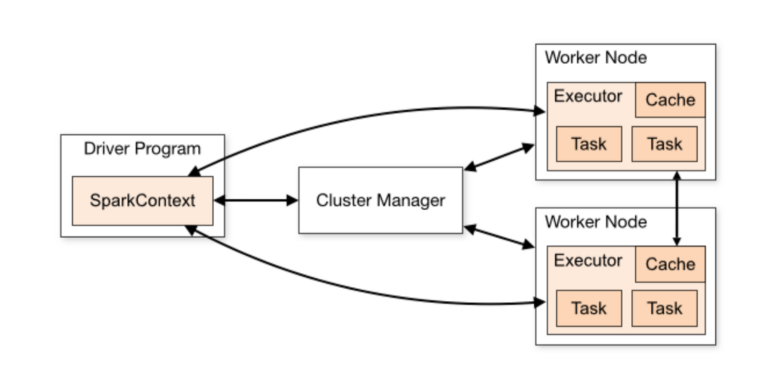

Nous allons comme auparavant créer un SparkContext sur un notebook python qui lance une JVM localement.
Ensuite ce programme driver se connectera à un Cluster Manager de type Kubernetes pour pouvoir lancer des workers.


#### Spark-shell versus Spark-submit (mode client et mode cluster)

Il est important, maintenant qu'on commence à manipuler des clusters spark, de rentrer dans ces détails d'architecture pour bien comprendre ce que l'on fait. 

Dans un **notebook jupyter nous faisons du spark shell** , à savoir que le datascientist peut intérargir avec son cluster spark en direct. C'est très séduisant mais néanmoins il ne faut pas oublier que pendant qu'on developpe et réfléchit à nos prochaines manipulations, notre application spark tourne déjà et reserve les ressources auprès du cluster. Il est donc recommandé de développer en intéractif avec moins de ressources et de plus petits jeux de données. 

A l'inverse, il est possible d'executer des **batchs spark**. Le programme s'arretant dès qu'il a fini son travail, il n'y a pas de gachis de ressources du à l'interaction et l'attente des commandes du datascientist.

Ces batchs sont executés via la commande **spark-submit**


Ce batch peut alors être executé dans deux modes de fonctionnement :
* le mode client dans lequel le driver spark est executé directement sur la jvm local.
* le mode cluster dans lequel le driver spark est executé sur un des noeuds du cluster spark.


Dans la suite de ce tutorial, je vais continuer à utiliser le shell interactif qui est parfaitement adapté au travail sur notebook.
Mais vous pouvez executer les examples de la distribution sur kubernetes sur un terminal (File-> New -> Terminal) en faisant du spark submit (mode batch).


#### mode client

on obtient la réponse directement sur le meme environemment que le spark-submit

In [1]:
! /opt/spark/bin/spark-submit \
    --deploy-mode client \
    --name spark-pi \
    --class org.apache.spark.examples.SparkPi \
    local:///opt/spark/examples/jars/spark-examples_2.12-${SPARK_VERSION}.jar

2022-10-10 08:19:05,928 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-10 08:19:07,494 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2022-10-10 08:19:07,768 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
Pi is roughly 3.143635718178591
2022-10-10 08:19:13,992 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


#### mode cluster

on va devoir donner un nom de pod pour le driver spark : ici "driver-spark".
Puis lire les logs de ce driver.

In [3]:
! /opt/spark/bin/spark-submit \
    --deploy-mode cluster \
    --name spark-pi \
    --conf spark.kubernetes.driver.pod.name=driver-spark \
    --class org.apache.spark.examples.SparkPi \
    local:///opt/spark/examples/jars/spark-examples_2.12-${SPARK_VERSION}.jar

2022-10-10 08:20:09,825 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
! kubectl logs driver-spark --tail 3

2022-10-10 08:20:17,389 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
Pi is roughly 3.140895704478522
2022-10-10 08:20:23,107 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


#### Pourquoi ca marche sans effort ? parce que Onyxia est sympa

Onyxia injecte une configuration par défaut pour votre configuration spark. Tous ces éléments sont ceux qu'Onyxia injecte à votre place. Vous pouvez les surcharger au runtime.


In [5]:
! cat /opt/spark/conf/spark-defaults.conf

spark.driver.extraJavaOptions -Dcom.amazonaws.sdk.disableCertChecking=false
spark.executor.extraJavaOptions -Dcom.amazonaws.sdk.disableCertChecking=false
spark.kubernetes.authenticate.driver.serviceAccountName jupyter-pyspark-584886
spark.kubernetes.container.image inseefrlab/onyxia-jupyter-pyspark:latest
spark.kubernetes.driver.pod.name jupyter-pyspark-584886-0
spark.kubernetes.namespace user-tm8enk
spark.master k8s://https://kubernetes.default.svc:443
spark.driver.memory 2g
spark.dynamicAllocation.enabled true
spark.dynamicAllocation.executorAllocationRatio 1
spark.dynamicAllocation.initialExecutors 1
spark.dynamicAllocation.maxExecutors 10
spark.dynamicAllocation.minExecutors 1
spark.dynamicAllocation.shuffleTracking.enabled true
spark.executor.memory 2g
spark.hadoop.fs.s3a.bucket.all.committer.magic.enabled true


#### Spark shell au sein d'un notebook

Pour plus d'interactivité, il est plus pratique de démarrer une **session spark interactive ( shell )** au sein du notebook.
On ne va pas modifier la configuration spark par défaut.
Elle est un peu évoluée car le nombre d'executeurs est dynamique et dépend des taches à faire.
Dans un shell ou le datascientist réflechit , c'est mieux de rendre cela dynamique (souvent il n'y a rien à faire) alors que pour du spark-submit vous avez peut etre envie d'avoir un nombre d'executeur fixe.

In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .getOrCreate()
        )

sc = spark.sparkContext

# Nom du compte de service pour contacter l'api kubernetes : attention le package du datalab crée lui même cette variable d'enviromment.
# Dans un pod du cluster kubernetes il faut lire le fichier /var/run/secrets/kubernetes.io/serviceaccount/token
# Néanmoins ce paramètre est inutile car le contexte kubernetes local de ce notebook est préconfiguré
# conf.set("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) 

# Paramètres d'enregistrement des logs spark d'application
# Attention ce paramètres nécessitent la création d'un dossier spark-history. Spark ne le fait pas lui même pour des raisons obscurs
# import s3fs
# endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
# fs.touch('s3://tm8enk/spark-history/.keep')
# sparkconf.set("spark.eventLog.enabled","true")
# sparkconf.set("spark.eventLog.dir","s3a://tm8enk/spark-history")

2022-10-10 08:57:39,871 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-10 08:57:40,644 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-10-10 08:57:41,515 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2022-10-10 08:57:41,768 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.


Le contexte spark se lance et si l'on utilise un terminal pour afficher l'ensemble des pods qui sont dans notre namespace, on voit que spark à lancer 1 executor car minExecutors=1 et initialExecutors=1

In [7]:
!kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-80f74883c0fd1f25-exec-1   1/1     Running   0          3m8s
pyspark-shell-aa668983b3620587-exec-1   1/1     Running   0          2d15h


#### Reprenons nos tweets sur fichier local

In [15]:
!mc cp s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv .

...o_2021.csv: 2.68 MiB / 2.68 MiB ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.87 MiB/s 0s

In [16]:
text_file = sc.textFile("trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1])

2022-10-07 17:01:17,997 WARN scheduler.TaskSetManager: Lost task 0.0 in stage 0.0 (TID 0) (10.233.127.230 executor 1): java.io.FileNotFoundException: File file:/home/onyxia/work/formation-spark/3-spark-kubernetes/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoo

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 4 times, most recent failure: Lost task 0.3 in stage 0.0 (TID 6) (10.233.127.230 executor 1): java.io.FileNotFoundException: File file:/home/onyxia/work/formation-spark/3-spark-kubernetes/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoop.fs.ChecksumFileSystem.openFileWithOptions(ChecksumFileSystem.java:894)
	at org.apache.hadoop.fs.FileSystem$FSDataInputStreamBuilder.build(FileSystem.java:4768)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:115)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:288)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:287)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:245)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:97)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.FileNotFoundException: File file:/home/onyxia/work/formation-spark/3-spark-kubernetes/trump_insult_tweets_2014_to_2021.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:779)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1100)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:769)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:160)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:372)
	at org.apache.hadoop.fs.ChecksumFileSystem.lambda$openFileWithOptions$0(ChecksumFileSystem.java:896)
	at org.apache.hadoop.util.LambdaUtils.eval(LambdaUtils.java:52)
	at org.apache.hadoop.fs.ChecksumFileSystem.openFileWithOptions(ChecksumFileSystem.java:894)
	at org.apache.hadoop.fs.FileSystem$FSDataInputStreamBuilder.build(FileSystem.java:4768)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:115)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:288)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:287)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:245)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:97)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


##### **pourquoi ?** 
Biensur c'est en erreur car le fichier n'est présent que localement sur le driver mais pas sur les executors.
Il est nécessaire absolument de s'appuyer sur une source non locale dès lors que l'on distribue les calculs sur un cluster. 
Sur fichier distant ca marche beaucoup mieux :

In [17]:
text_file = sc.textFile("s3a://projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1] )

counts.take(20)

[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

In [2]:
! pip install s3fs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 855.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 779.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 481.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 759.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 544.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 487.9 kB/s eta 0:00:00a 0:00:01


### Plus de détails sur l'allocation dynamique

Ici on va déclarer un dataframe basé sur sirene.csv mais en injectant le schema comme une donnée d'input; Spark ne va pas donc pas lire le fichier pour en déduire le schéma.

In [3]:
import json
from pyspark.sql.types import StructType
import s3fs
import os

endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
    a = f.read()
    schema = StructType.fromJson(json.loads(a))

In [4]:
df = (spark.read
      .format("csv")
      .options(header='true', inferschema='false', delimiter=',')
      .schema(schema)
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

df.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

In [5]:
! kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-6561c783c10eba07-exec-1   1/1     Running   0          96s


La requête first ne nécessite aucun parallélisme puisqu'on ne lit qu'une seule partition de donnée pour être en mesure de répondre. Tout est immédiat.

**Augmentons le nombre de taches**

Pour cela nous allons forcer la lecture de tout le csv. Cela se fera en fonction du nombre de partition du dataframe original. En effet spark dans sa configuration par défaut travaille sur 128 Mo de données et va donc découper le job sur les 6,5 Go en 53 taches


In [6]:
%%timeit -r3
print(df.count())

69911542


69911542


69911542


69911542
10.2 s ± 300 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [7]:
! kubectl get pods -l spark-role=executor

NAME                                     READY   STATUS    RESTARTS   AGE
pyspark-shell-6561c783c10eba07-exec-1    1/1     Running   0          4m12s
pyspark-shell-6561c783c10eba07-exec-10   1/1     Running   0          81s
pyspark-shell-6561c783c10eba07-exec-2    1/1     Running   0          85s
pyspark-shell-6561c783c10eba07-exec-3    1/1     Running   0          84s
pyspark-shell-6561c783c10eba07-exec-4    1/1     Running   0          84s
pyspark-shell-6561c783c10eba07-exec-5    1/1     Running   0          83s
pyspark-shell-6561c783c10eba07-exec-6    1/1     Running   0          83s
pyspark-shell-6561c783c10eba07-exec-7    1/1     Running   0          83s
pyspark-shell-6561c783c10eba07-exec-8    1/1     Running   0          83s
pyspark-shell-6561c783c10eba07-exec-9    1/1     Running   0          82s


On a bien dix executeurs spark ( maximum autorisé par la configuration spark par défaut fournit par Onyxia) 

### Comment faire pour figer le nombre d'executeur spark ?

Il est possible de faire une configuration statique et pour cela on va redemarrer la session spark en surchargeant la configuration apr défaut fournit par Onyxia.

In [9]:
spark.stop()

2022-10-10 08:48:15,573 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


In [10]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .config("spark.dynamicAllocation.enabled","false")
         .config("spark.executor.instances","5")
         .getOrCreate()
        )

sc = spark.sparkContext

In [12]:
!kubectl get pods -l spark-role=executor

NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-35b0cd83c1149fce-exec-1   1/1     Running   0          24s
pyspark-shell-35b0cd83c1149fce-exec-2   1/1     Running   0          24s
pyspark-shell-35b0cd83c1149fce-exec-3   1/1     Running   0          24s
pyspark-shell-35b0cd83c1149fce-exec-4   1/1     Running   0          24s
pyspark-shell-35b0cd83c1149fce-exec-5   1/1     Running   0          24s


## Conclusion

Nous avons vu les différents concepts sur l'infrastructure spark dans un contexte kubernetes tout comme l'interet d'externaliser la source de donnée sur un stockage distant. Spark-submit pour les batchs et les sessions spark interactives au sein du notebook.

In [ ]:
spark.stop()